In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Nissan.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_100 NX,Seri_200 SX,Seri_350 Z,...,Model_2.0 Turbo,Model_2.3i,Model_Coupe,Model_NX,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,479900,-0.181818,-0.611111,-1.538462,-1.183521,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,485000,0.545455,-0.611111,-1.740385,-1.258427,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,315000,-1.000000,-0.055556,0.177885,-0.704120,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,285000,-0.454545,-0.611111,-1.538462,0.000000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,487000,0.000000,-0.611111,-1.740385,-1.183521,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_11588\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,92733.078551,1.942017e+09,44068.317364,32107.73609


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:16:40,972] A new study created in memory with name: no-name-b3f6aa98-b7f2-4427-b752-25e5fc4f0e5b
[I 2023-05-23 21:16:41,089] Trial 0 finished with value: 363100.34282996267 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.00016486818775705842, 'max_depth': 9, 'min_child_weight': 158}. Best is trial 0 with value: 363100.34282996267.
[I 2023-05-23 21:16:41,093] Trial 2 finished with value: 361330.875501474 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.0006982356624054577, 'max_depth': 10, 'min_child_weight': 169}. Best is trial 2 with value: 361330.875501474.
[I 2023-05-23 21:16:41,095] Trial 3 finished with value: 361205.6928794725 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.000736080463103002, 'max_depth': 14, 'min_child_weight': 155}. Best is trial 3 with value: 361205.6928794725.
[I 2023-05-23 21:16:41,096] Trial 1 finished with value: 73324.45167330079 and parameters: {

[I 2023-05-23 21:16:42,062] Trial 30 finished with value: 118173.79894665474 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1077332551555382, 'max_depth': 5, 'min_child_weight': 42}. Best is trial 18 with value: 43961.09801443045.
[I 2023-05-23 21:16:42,067] Trial 31 finished with value: 126486.18645258335 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.10237700751332196, 'max_depth': 5, 'min_child_weight': 55}. Best is trial 18 with value: 43961.09801443045.
[I 2023-05-23 21:16:42,149] Trial 32 finished with value: 141663.80418100316 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.09057595063051617, 'max_depth': 5, 'min_child_weight': 53}. Best is trial 18 with value: 43961.09801443045.
[I 2023-05-23 21:16:42,197] Trial 33 finished with value: 155770.2598021739 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.0834064010902845, 'max_depth': 5, 'min_child_weight': 

[I 2023-05-23 21:16:43,536] Trial 60 finished with value: 68741.32774304909 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.359404202860035, 'max_depth': 3, 'min_child_weight': 19}. Best is trial 18 with value: 43961.09801443045.
[I 2023-05-23 21:16:43,559] Trial 61 finished with value: 68773.00689890541 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.3648688818738892, 'max_depth': 3, 'min_child_weight': 19}. Best is trial 18 with value: 43961.09801443045.
[I 2023-05-23 21:16:43,689] Trial 62 finished with value: 66556.89044545274 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.3784022036681636, 'max_depth': 3, 'min_child_weight': 6}. Best is trial 18 with value: 43961.09801443045.
[I 2023-05-23 21:16:43,749] Trial 63 finished with value: 52348.35500982288 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.3739509838814288, 'max_depth': 3, 'min_child_weight': 2}. Bes

[I 2023-05-23 21:16:44,993] Trial 90 finished with value: 60871.98510155315 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.24227360423668992, 'max_depth': 15, 'min_child_weight': 61}. Best is trial 74 with value: 41706.42139784894.
[I 2023-05-23 21:16:45,043] Trial 92 finished with value: 48011.739305608105 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.26237008280021346, 'max_depth': 14, 'min_child_weight': 1}. Best is trial 74 with value: 41706.42139784894.
[I 2023-05-23 21:16:45,055] Trial 93 finished with value: 130043.81396213816 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.24382652693210644, 'max_depth': 15, 'min_child_weight': 143}. Best is trial 74 with value: 41706.42139784894.
[I 2023-05-23 21:16:45,062] Trial 91 finished with value: 47990.638707516824 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.26198817555512494, 'max_depth': 15, 'min_child_wei

[I 2023-05-23 21:16:46,568] Trial 120 finished with value: 61526.4352403025 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.2944551660079831, 'max_depth': 9, 'min_child_weight': 37}. Best is trial 74 with value: 41706.42139784894.
[I 2023-05-23 21:16:46,592] Trial 121 finished with value: 61501.47161202891 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.2900877825557905, 'max_depth': 9, 'min_child_weight': 37}. Best is trial 74 with value: 41706.42139784894.
[I 2023-05-23 21:16:46,618] Trial 122 finished with value: 57999.5575862112 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.25700338886732293, 'max_depth': 9, 'min_child_weight': 36}. Best is trial 74 with value: 41706.42139784894.
[I 2023-05-23 21:16:46,676] Trial 123 finished with value: 61768.18792399535 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.31268453157957726, 'max_depth': 9, 'min_child_weight': 3

[I 2023-05-23 21:16:48,088] Trial 150 finished with value: 80429.42482857963 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4075211035348461, 'max_depth': 15, 'min_child_weight': 7}. Best is trial 74 with value: 41706.42139784894.
[I 2023-05-23 21:16:48,297] Trial 151 finished with value: 64545.627361146755 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4095725877787643, 'max_depth': 12, 'min_child_weight': 23}. Best is trial 74 with value: 41706.42139784894.
[I 2023-05-23 21:16:48,318] Trial 152 finished with value: 40025.201963264226 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4228380829399864, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 152 with value: 40025.201963264226.
[I 2023-05-23 21:16:48,319] Trial 153 finished with value: 63061.03723811453 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.42768943318758534, 'max_depth': 12, 'min_child_weig

[I 2023-05-23 21:16:49,737] Trial 179 finished with value: 131210.61521335912 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.33974339710496987, 'max_depth': 12, 'min_child_weight': 157}. Best is trial 152 with value: 40025.201963264226.
[I 2023-05-23 21:16:49,750] Trial 180 finished with value: 57378.574508167054 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.32117425825787094, 'max_depth': 3, 'min_child_weight': 10}. Best is trial 152 with value: 40025.201963264226.
[I 2023-05-23 21:16:49,912] Trial 182 finished with value: 59547.22425751748 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.33497719857798797, 'max_depth': 3, 'min_child_weight': 10}. Best is trial 152 with value: 40025.201963264226.
[I 2023-05-23 21:16:50,076] Trial 183 finished with value: 41958.95819641313 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.32918155157402135, 'max_depth': 14, 'min_c

[I 2023-05-23 21:16:51,638] Trial 209 finished with value: 50803.114912795936 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.38856867623551256, 'max_depth': 14, 'min_child_weight': 1}. Best is trial 152 with value: 40025.201963264226.
[I 2023-05-23 21:16:51,701] Trial 212 finished with value: 46019.368791177105 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.4866070232153933, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 152 with value: 40025.201963264226.
[I 2023-05-23 21:16:51,714] Trial 211 finished with value: 70272.76475332286 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.49459742394988615, 'max_depth': 14, 'min_child_weight': 7}. Best is trial 152 with value: 40025.201963264226.
[I 2023-05-23 21:16:51,756] Trial 213 finished with value: 47815.13285182836 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.47339537157797396, 'max_depth': 14, 'min_child

[I 2023-05-23 21:16:53,614] Trial 240 finished with value: 43570.97166045098 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.4414824247502419, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 152 with value: 40025.201963264226.
[I 2023-05-23 21:16:53,650] Trial 241 finished with value: 72256.73292600138 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.43059561375936267, 'max_depth': 15, 'min_child_weight': 13}. Best is trial 152 with value: 40025.201963264226.
[I 2023-05-23 21:16:53,693] Trial 242 finished with value: 43127.401647009596 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.43313161469355455, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 152 with value: 40025.201963264226.
[I 2023-05-23 21:16:53,718] Trial 245 finished with value: 64401.49221051045 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.4390565877718347, 'max_depth': 15, 'min_child

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 40025.2020
Best params:
	colsample_bytree: 1.0
	subsample: 0.7
	learning_rate: 0.4228380829399864
	max_depth: 3
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [3,7],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [1],
               'subsample': [0.7],
               'min_child_weight': [1]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.7}
{'TestDeger': 91979.2711832973, 'MSE': 2167379328.2080216, 'RMSE': 46555.12139612592, 'MAE': 31420.780360772358}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.8718008154531068

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8306578213427085

In [17]:
marka_model = joblib.dump(grid_final_model, "Nissan.pkl")

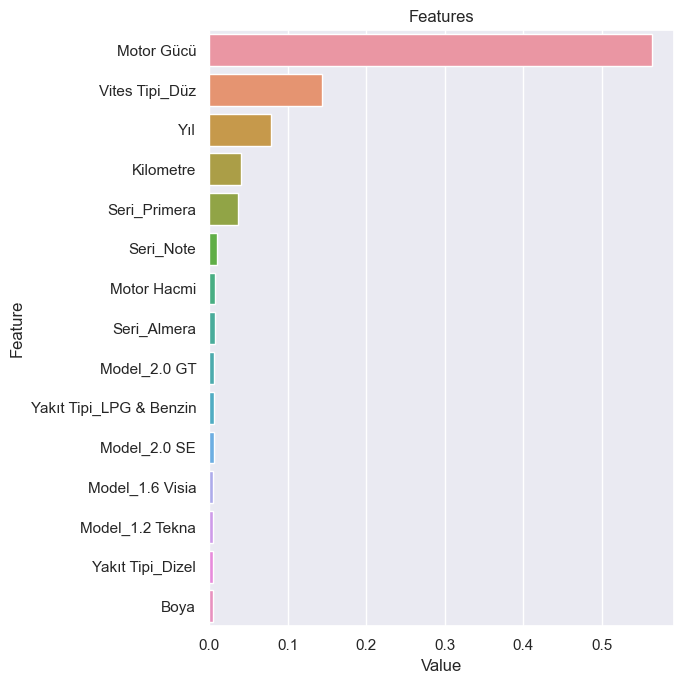

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)